In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from tqdm.autonotebook import tqdm, trange
import itertools
from matplotlib import pyplot as plt
import matplotlib.colors

import pandas as pd
import sklearn 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import r2_score
from tensorflow.keras import layers
import time
import random

import importlib
import evaluation
import load_data
import Padgan_variants
import VAEs

importlib.reload(evaluation)
importlib.reload(load_data)
importlib.reload(VAEs)
importlib.reload(Padgan_variants)

C:\Users\Lyle\AppData\Local\Temp\ipykernel_19672\3522141642.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


<module 'Padgan_variants' from 'C:\\Users\\Lyle\\Documents\\DeCoDE\\DGM-Evaluation-Metrics\\Padgan_variants.py'>

In [2]:
def fit_and_generate(functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status):
    
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    
    #Initialize np array to hold generated samples
    generated = np.zeros((len(functions), len(methods), numinst, numgen, 2))

    #Loop over number of model instantiations to test
    for inst in range(numinst):
        #Loop over the problems to test
        for func in range(len(functions)):
            #Unpack various problem parameters
            samplingfunction, validityfunction, objectives, rangearr, cond_func, cond = functions[func]
            
            #Generate the data
            valid_scaled, invalid_scaled, scaler = load_data.gen_toy_dataset(samplingfunction, validityfunction, objectives, rangearr, scaling)
            
            #Get some unscaled versions of the data to use for calculating objectives/condition parameters
            if scaling: 
                valid = scaler.inverse_transform(valid_scaled)
            else:
                valid = valid_scaled
                
            #Evaluate objective values for all datapoints
            if obj_status:
                y_valid = load_data.eval_obj(valid, objectives)
            else:
                y_valid = None
            
            #Evaluate condition value for all datapoints
            if conditional_status:
                c_valid = load_data.eval_obj(valid, [cond_func])
            else:
                c_valid = None
            #Loop over DGMs
            for i in range(len(methods)): 
                method = methods.values[i]
                
                #Get trained model
                model = method(valid_scaled, invalid_scaled, y_valid, c_valid)
                
                #Call generate function (models are assumed to have a class function, generate)
                x_fake_scaled = model.generate(numgen, np.full(numgen, cond))
                
                #Add to generated results array
                x_fake_scaled = np.array(x_fake_scaled)
                generated[func, i, inst, :, :] = x_fake_scaled

    #Save and return results
    np.save(f"Scores/Generated_samples_{timestr}.npy", generated)
    return generated, timestr


In [3]:
def plot(ax, rangearr, xx, yy, Z, x, y, x2,y2, title, boundary=0.0, colors=["#FC766A", "#5B84B1"], plottype = "generated", validity_status=0, target=None):
    
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
    plt.rc('font', **font)
    
    vdatacol="#000000"
    blue = "#6C8EBF"
    orange = "#F2AF00"
    yellow = "#D6B656"
    white = "#FFFFFF"
    purple = "#9673A6"
    vgencol = orange
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#FFFFFF","#6C8EBF"], N=7)
    objcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [white , orange], N=6)
    
    s=6
    ax.set_title(title)
    if validity_status==1: #Invalid Samples
        if plottype == "dataset":
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
            ax.scatter(x,y, s=s, c=["#6C8EBF"], alpha=0.5)
        elif plottype == "invalid":
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
            ax.scatter(x,y, s=s, c=["#000000"], alpha=0.2)
        elif plottype == "generated":
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
            ax.scatter(x,y, s=s, c=["#6C8EBF"])
            ax.scatter(x2,y2, s=s, c=["#000000"])
        elif plottype == "objective":
            img = ax.imshow(Z.T, cmap=objcmap, alpha=0.7, origin='lower', extent = [-2,2,-2,2])    
            plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
            ax.scatter(x,y, s=s, c="k", alpha = 0.3)
            if target:
                CS = ax.contour(Z.T, [target], colors='k', vmin=0, vmax=2, extent = [-2,2,-2,2])
                ax.clabel(CS, fontsize=30, inline=True)
#                 manual_locations = [(-2, 2), (2,-2)]
#                 ax.clabel(CS, fontsize=30, inline=True, manual=manual_locations)
    else:
        if plottype=="objective":
            img = ax.imshow(Z.T, cmap=objcmap, alpha=0.5, origin='lower', extent = [-2,2,-2,2])
            plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
            ax.scatter(x,y, s=s, c="k", alpha = 0.3)
            if target:
                CS = ax.contour(Z.T, [target], colors='k', vmin=0, vmax=2, extent = [-2,2,-2,2])
                ax.clabel(CS, fontsize=30, inline=True)
#                 manual_locations = [(-2, 2), (2,-2)]
#                 ax.clabel(CS, fontsize=30, inline=True, manual=manual_locations)
            
        elif plottype=="dataset": #No invalid Samples
            ax.scatter(x,y, s=s, c=vdatacol, alpha=0.15)
            ax.set_title("Original Data")
        elif plottype=="generated":
            ax.scatter(x2,y2, s=s, c=vdatacol, alpha=0.05)
            ax.scatter(x,y, s=s, c=vgencol, alpha=0.7)
        elif plottype=="conditional":
            ax.scatter(x2,y2, s=s, c=vdatacol, alpha=0.1)
            ax.scatter(x,y, s=s, c=vgencol, alpha=0.7)
    xlen = rangearr[0,1]-rangearr[0,0]
    ylen = rangearr[1,1]-rangearr[1,0]
    ax.set_xlim(rangearr[0,0]-xlen*boundary, rangearr[0,1]+xlen*boundary)
    ax.set_ylim(rangearr[1,0]-ylen*boundary, rangearr[1,1]+ylen*boundary)
    ax.axis('off')

In [4]:
def score_and_plot(generated, timestr, functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status, cond_dist, plotobjs=None):
    scores=np.zeros((len(functions), len(methods), len(metrics), numinst))

    #Find the highest number of objectives in any problem
    max_obj = 0
    if obj_status:
        for i in range(len(functions)):
            if len(functions[i][2])>max_obj:
                max_obj = len(functions[i][2])
        
    
    #Calculate how many plots per row we will be generating
    plots_in_row = 1 + validity_status +(len(methods)*(1+cond_dist)+max_obj*obj_status + conditional_status+cond_dist)

    #Loop over training instances
    for inst in range(numinst):
        #Initialize subplots
        fig, ax = plt.subplots(len(functions), plots_in_row, figsize=(10*plots_in_row-0.2, 10*len(functions)-0.9))

        #Loop over problems to test
        for func in range(len(functions)):
            #Unpack problem info
            samplingfunction, validityfunction, objectives, rangearr, cond_func, cond = functions[func]
            
            #Generate the data
            valid_scaled, invalid_scaled, scaler = load_data.gen_toy_dataset(samplingfunction, validityfunction, objectives, rangearr, scaling)

            #Get some unscaled versions for plotting
            if scaling: 
                valid = scaler.inverse_transform(valid_scaled)
                try:
                    invalid = scaler.inverse_transform(invalid_scaled)
                except:
                    invalid = np.array([[None,None]])
            else:
                valid = valid_scaled
                invalid = invalid_scaled

            #Evaluate objective values for all datapoints
            if objectives:
                y_valid = load_data.eval_obj(valid, objectives)
                
                #If rediscovery in metrics, split valid and y_valid
                if "Rediscovery" in metrics:
                    valid_scaled, vr, y_valid, yr = train_test_split(valid_scaled, y_valid, test_size=0.05, random_state=0)
            else:
                #If rediscovery in metrics, split valid
                y_valid = None
                if "Rediscovery" in metrics:
                    valid_scaled, vr = train_test_split(valid_scaled, test_size=0.05, random_state=0)
                yr = None
                
                    
            xx, yy, Z = load_data.gen_background_plot(validityfunction, rangearr)
            plot(fig.axes[plots_in_row*func], rangearr, xx, yy, Z, valid[:,0], valid[:,1], None, None, 
                 "Original valid data", validity_status=validity_status, plottype = "dataset")
            if validity_status==1:
                plot(fig.axes[plots_in_row*func+1], rangearr, xx, yy, Z, invalid[:,0], invalid[:,1], None, None, 
                     "Original invalid data", validity_status=validity_status, plottype = "invalid")
            if obj_status:
                num_objectives = len(objectives)
                for i in range(num_objectives):
                    xx_o, yy_o, Z_o = load_data.gen_background_plot(objectives[i], rangearr)
                    obj_idx = plots_in_row*func+1+validity_status+i
                    plot(fig.axes[obj_idx], rangearr, xx_o, yy_o, Z_o, valid[:,0], valid[:,1], None, None, "Objective " +str(i+1), 
                         plottype = "objective", validity_status=validity_status, target=plotobjs[i])
            else:
                num_objectives = 0
            if conditional_status:
                c_valid = load_data.eval_obj(valid, [cond_func])
                
                xx_o, yy_o, Z_o = load_data.gen_background_plot(cond_func, rangearr)
                cond_idx=plots_in_row*func+1+validity_status+num_objectives*obj_status
                plot(fig.axes[cond_idx], rangearr, xx_o, yy_o, Z_o, valid[:,0], valid[:,1], None, None, "", 
                         plottype = "objective", validity_status=validity_status, target=plotobjs[num_objectives])
                
            if cond_dist:
                mask = evaluation.get_perc_band(cond, c_valid, 0.1)
                valid_mask = valid[mask]
                if objectives:
                    y_valid_mask = y_valid[mask]
                else:
                    y_valid_mask = None
                valid_scaled_mask = valid_scaled[mask]
                cond_mask = c_valid[mask]

                
                
            #Loop over methods to test
            for i in range(len(methods)): 
                if cond_dist:
                    plot(fig.axes[cond_idx+1], rangearr, xx, yy, Z, valid_mask[:,0], valid_mask[:,1], None, None,
                             methods.index[i], validity_status=validity_status, plottype = "dataset")
                    
                x_fake_scaled = generated[func, i, inst, :, :]
                
                if scaling==True:
                    x_fake = scaler.inverse_transform(x_fake_scaled)
                else:
                    x_fake = x_fake_scaled
                    
                if objectives:
                    y_fake = load_data.eval_obj(x_fake, objectives)
                else:
                    y_fake = None
                

                for j in range(len(metrics)):
                    if metrics.index[j]=="Validity":
                        allscores, meanscore = evaluation.evaluate_validity(x_fake, validityfunction)
                    elif metrics.index[j]=="Rediscovery":
                        allscores, meanscore = metrics.values[j](x_fake_scaled, y_fake, vr, yr, invalid_scaled, scorebars)
                    elif metrics.index[j]=="Conditioning Reconstruction":
                        allscores, meanscore = metrics.values[j](x_fake_scaled, y_fake, valid_scaled, c_valid, invalid_scaled, scorebars)
                    elif metrics.index[j]=="Conditioning Adherence":
                        c_gen = load_data.eval_obj(x_fake, [cond_func])
                        allscores=None
                        meanscore = sklearn.metrics.mean_squared_error(c_gen, np.ones_like(c_gen)*cond)
                    else:
                        if cond_dist:
                            allscores, meanscore = metrics.values[j](x_fake_scaled, y_fake, valid_scaled_mask, y_valid_mask, invalid_scaled, scorebars)
                        else:
                            allscores, meanscore = metrics.values[j](x_fake_scaled, y_fake, valid_scaled, y_valid, invalid_scaled, scorebars)
                    scores[func, i, j, inst] = meanscore
                res_idx=plots_in_row*func+1+validity_status+max_obj*obj_status+i*(1+cond_dist)+conditional_status+cond_dist
                if validity_status:
                    labels, _ = evaluation.evaluate_validity(x_fake, validityfunction)
                    labels = labels.astype(bool)
                    plot(fig.axes[res_idx], rangearr, xx, yy, Z, x_fake[:,0][labels], x_fake[:,1][labels], x_fake[:,0][~labels], x_fake[:,1][~labels], 
                         methods.index[i], plottype="generated", validity_status = validity_status)                
                else:
                    plot(fig.axes[res_idx], rangearr, xx, yy, Z, x_fake[:,0], x_fake[:,1], valid[:,0], valid[:,1], methods.index[i], 
                         plottype="generated", validity_status = validity_status)
                if cond_dist:
                    plot(fig.axes[res_idx+1], rangearr, xx, yy, Z, x_fake[:,0], x_fake[:,1], valid_mask[:,0], valid_mask[:,1],
                         methods.index[i], validity_status=validity_status, plottype = "conditional")
        plt.show()
        fig.savefig(f"Scores/{inst}_{timestr}.png", dpi=400)

    for i in range(np.shape(scores)[0]):
        meanscores = np.mean(scores[i], axis=(2))
        scoredf = pd.DataFrame(meanscores, index=methods.index, columns = metrics.index).transpose()
        scoredf.columns.name=f"Problem {i+1} Scores:"
        scoredf.to_csv(f"Scores/problem_{i+1}_{timestr}.csv", index_label=scoredf.columns.name)
        print(scoredf)

    #average scores

    meanscores = np.mean(scores, axis=(0,3))
    scoredf = pd.DataFrame(meanscores, index=methods.index, columns = metrics.index).transpose()
    scoredf.columns.name="Average scores:"
    print(scoredf)
    scoredf.to_csv(f"Scores/{timestr}.csv", index_label=scoredf.columns.name)

**General Settings**

In [5]:
numgen = 1000 #Number of samples to generate
numinst = 1 #Number of instantiations to test
scaling = True #Scale or not
scorebars = True #Print progress bars for scoring functions

np.random.seed(0)

**Similarity**

C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\1366272667.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  methods=pd.Series()
C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\1366272667.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics=pd.Series()


Lambda1 set to 0, DPP loss disabled; Ignoring CLF and REG...


GAN Training::   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1/100
79/79 [==============================] - 1s 6ms/step - loss: 0.7338 - reconstruction_loss: 0.3685 - kl_loss: 2.3529
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 0.2232 - reconstruction_loss: 0.0623 - kl_loss: 2.9929
Epoch 3/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1900 - reconstruction_loss: 0.0498 - kl_loss: 2.7544
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1813 - reconstruction_loss: 0.0478 - kl_loss: 2.6401
Epoch 5/100
79/79 [==============================] - 1s 6ms/step - loss: 0.1781 - reconstruction_loss: 0.0463 - kl_loss: 2.6125
Epoch 6/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1741 - reconstruction_loss: 0.0463 - kl_loss: 2.5341
Epoch 7/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1692 - reconstruction_loss: 0.0448 - kl_loss: 2.4845
Epoch 8/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1712 - reconstruction_loss: 0

Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:03<00:00,  2.91it/s]


Calculating F10


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:03<00:00,  2.92it/s]


Calculating F0.1


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:03<00:00,  3.00it/s]


Calculating AUC


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:03<00:00,  2.90it/s]


Calculating Maximum Mean Discrepancy
Calculating ML Efficacy
Calculating Gen-Data Distance
Calculating Data-Gen Distance
Calculating Data-Gen Distance
Calculating F1


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:03<00:00,  2.76it/s]


Calculating F10


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:03<00:00,  2.73it/s]


Calculating F0.1


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:03<00:00,  2.62it/s]


Calculating AUC


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:03<00:00,  2.77it/s]


Calculating Maximum Mean Discrepancy
Calculating ML Efficacy


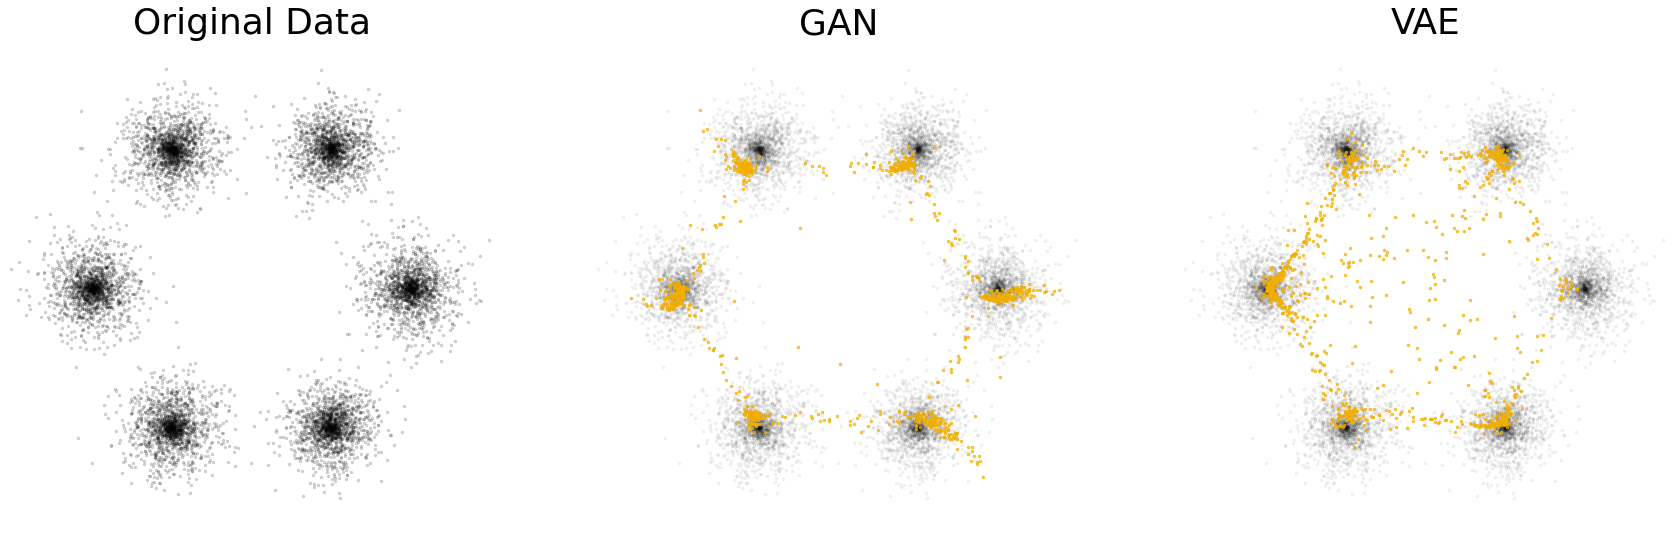

Problem 1 Scores:              GAN       VAE
Nearest Dataset Sample    0.013968  0.040277
Nearest Generated Sample  0.087319  0.094248
Rediscovery               0.080325  0.086968
F1                        0.604965  0.581588
F10                       0.962519  0.907095
F0.1                      0.783089  0.804232
AUC-PR                    0.605823  0.590015
MMD                       0.006381  0.050613
ML Efficacy               0.781509  0.764506
Average scores:                GAN       VAE
Nearest Dataset Sample    0.013968  0.040277
Nearest Generated Sample  0.087319  0.094248
Rediscovery               0.080325  0.086968
F1                        0.604965  0.581588
F10                       0.962519  0.907095
F0.1                      0.783089  0.804232
AUC-PR                    0.605823  0.590015
MMD                       0.006381  0.050613
ML Efficacy               0.781509  0.764506


In [6]:
functions=[]

DM_val = load_data.all_val_wrapper()

#In this case, we include objectives specifically for ML efficacy
DM_objs = [load_data.KNO1_a_wrapper(4,4), load_data.KNO1_b_wrapper(4,4)] 

pareto = np.stack([0.4705*np.linspace(0,1,1000), 0.4705*np.linspace(1,0,1000)], axis=1)
sampling_func = load_data.sample_circle_blobs_wrapper(10000, 6, 1.3, 0.22) #Uniform Sampling with Number of positive samples & Negative Samples

rangearr = np.array([[-2,2], [-2,2]])
functions.append([sampling_func, DM_val, DM_objs, rangearr, None, None])

reg_clf_params = None
config_params = [False, False, False, None, None, False]
train_params = [1, 0, 4, 5000] #Setting DPP weight to 0 for normal GAN
DTAI_params= [None, None, None]

methods=pd.Series()
methods["GAN"] = Padgan_variants.padgan_wrapper(config_params, train_params, DTAI_params, reg_clf_params, reg_clf_params)
methods["VAE"] = VAEs.VAE_wrapper([100, 128, 1e-3, 4, .05, False])

metrics=pd.Series()
metrics["Nearest Dataset Sample"] = evaluation.gen_data_distance_wrapper("x", "min")
metrics["Nearest Generated Sample"] = evaluation.data_gen_distance_wrapper("x", "min")
metrics["Rediscovery"] = evaluation.data_gen_distance_wrapper("x", "min")
metrics["F1"] = evaluation.F_wrapper("x", 1)
metrics["F10"] = evaluation.F_wrapper("x", 10)
metrics["F0.1"] = evaluation.F_wrapper("x", 0.1)
metrics["AUC-PR"] = evaluation.AUC_wrapper("x")
metrics["MMD"] = evaluation.MMD_wrapper()
metrics["ML Efficacy"] = evaluation.ML_efficacy_wrapper(KNeighborsRegressor(n_neighbors=5), r2_score)


validity_status = 0 #whether we are considering constraints
obj_status = 0 #wheteher we are considering functional perfomrance
conditional_status = 0 #whether we are considering conditioning
cond_dist=False #Whether conditional metrics are compared against conditional or marginal distribution

generated, timestr = fit_and_generate(functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status)
score_and_plot(generated, timestr, functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status, cond_dist)

**Diversity**

Lambda1 set to 0, DPP loss disabled; Ignoring CLF and REG...


C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\1782383705.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  methods=pd.Series()
C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\1782383705.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics=pd.Series()


GAN Training::   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1/100
79/79 [==============================] - 1s 6ms/step - loss: 0.7373 - reconstruction_loss: 0.3636 - kl_loss: 2.2820
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 0.2097 - reconstruction_loss: 0.0566 - kl_loss: 2.8675
Epoch 3/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1867 - reconstruction_loss: 0.0501 - kl_loss: 2.7167
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1826 - reconstruction_loss: 0.0489 - kl_loss: 2.6319
Epoch 5/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1767 - reconstruction_loss: 0.0459 - kl_loss: 2.5863
Epoch 6/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1727 - reconstruction_loss: 0.0453 - kl_loss: 2.5491
Epoch 7/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1694 - reconstruction_loss: 0.0451 - kl_loss: 2.4968
Epoch 8/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1729 - reconstruction_loss: 0

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Calculating Distance to Centroid


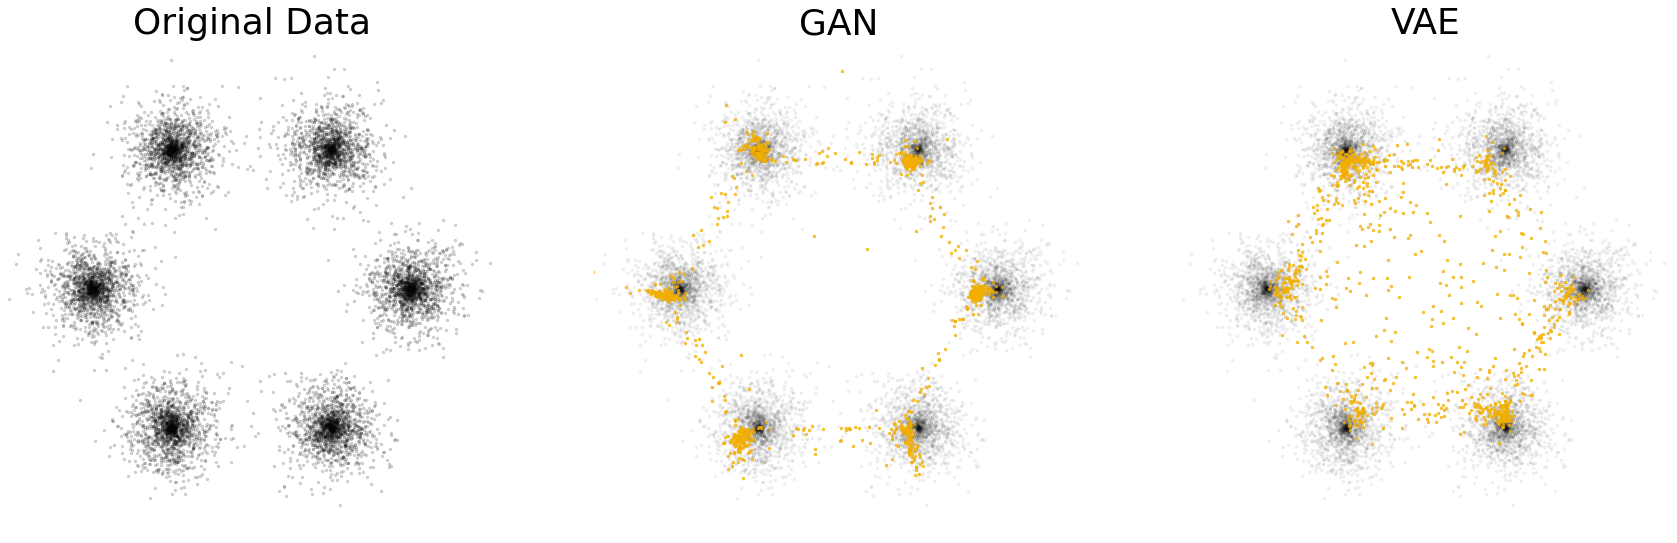

Problem 1 Scores:               GAN        VAE
Inter-Generated Sample     0.019279   0.031028
Convex Hull                8.763061   5.599979
DPP Diversity             14.666122  14.412344
Nearest Generated Sample   0.079034   0.095852
Distance to Centroid       1.370775   1.114886
Average scores:                 GAN        VAE
Inter-Generated Sample     0.019279   0.031028
Convex Hull                8.763061   5.599979
DPP Diversity             14.666122  14.412344
Nearest Generated Sample   0.079034   0.095852
Distance to Centroid       1.370775   1.114886


In [7]:
functions=[]

DM_val = load_data.all_val_wrapper()
pareto = np.stack([0.4705*np.linspace(0,1,1000), 0.4705*np.linspace(1,0,1000)], axis=1)
sampling_func = load_data.sample_circle_blobs_wrapper(10000, 6, 1.3, 0.22) #Uniform Sampling with Number of positive samples & Negative Samples

rangearr = np.array([[-2,2], [-2,2]])
functions.append([sampling_func, DM_val, None, rangearr, None, None])

reg_clf_params = None
config_params = [False, False, False, None, None, False]
train_params = [1, 0, 4, 5000] #Setting DPP weight to 0 for normal GAN
DTAI_params= [None, None, None]

methods=pd.Series()
methods["GAN"] = Padgan_variants.padgan_wrapper(config_params, train_params, DTAI_params, reg_clf_params, reg_clf_params)
methods["VAE"] = VAEs.VAE_wrapper([100, 128, 1e-3, 4, .05, False])


metrics=pd.Series()
metrics["Inter-Generated Sample"] = evaluation.gen_gen_distance_wrapper("x", "min")
metrics["Convex Hull"] = evaluation.convex_hull_wrapper("x")
metrics["DPP Diversity"] = evaluation.DPP_diversity_wrapper("x")
metrics["Nearest Generated Sample"] = evaluation.data_gen_distance_wrapper("x", "min")
metrics["Distance to Centroid"] = evaluation.distance_to_centroid_wrapper("x")


validity_status = 0 #whether we are considering constraints
obj_status = 0 #wheteher we are considering functional perfomrance
conditional_status = 0 #whether we are considering conditioning
cond_dist=False #Whether conditional metrics are compared against conditional or marginal distribution

generated, timestr = fit_and_generate(functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status)
score_and_plot(generated, timestr, functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status, cond_dist)


**Constraint Adherence**

C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\2023594381.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  methods=pd.Series()
C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\2023594381.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics=pd.Series()


Lambda1 set to 0, DPP loss disabled; Ignoring CLF and REG...


GAN Training::   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1/100
79/79 [==============================] - 1s 7ms/step - loss: 0.7437 - reconstruction_loss: 0.3764 - kl_loss: 2.3653
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 0.2343 - reconstruction_loss: 0.0699 - kl_loss: 3.0570
Epoch 3/100
79/79 [==============================] - 1s 7ms/step - loss: 0.2109 - reconstruction_loss: 0.0592 - kl_loss: 2.9773
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 0.2019 - reconstruction_loss: 0.0548 - kl_loss: 2.9314
Epoch 5/100
79/79 [==============================] - 1s 7ms/step - loss: 0.2007 - reconstruction_loss: 0.0543 - kl_loss: 2.9309
Epoch 6/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1993 - reconstruction_loss: 0.0534 - kl_loss: 2.9041
Epoch 7/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1987 - reconstruction_loss: 0.0546 - kl_loss: 2.8796
Epoch 8/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1986 - reconstruction_loss: 0

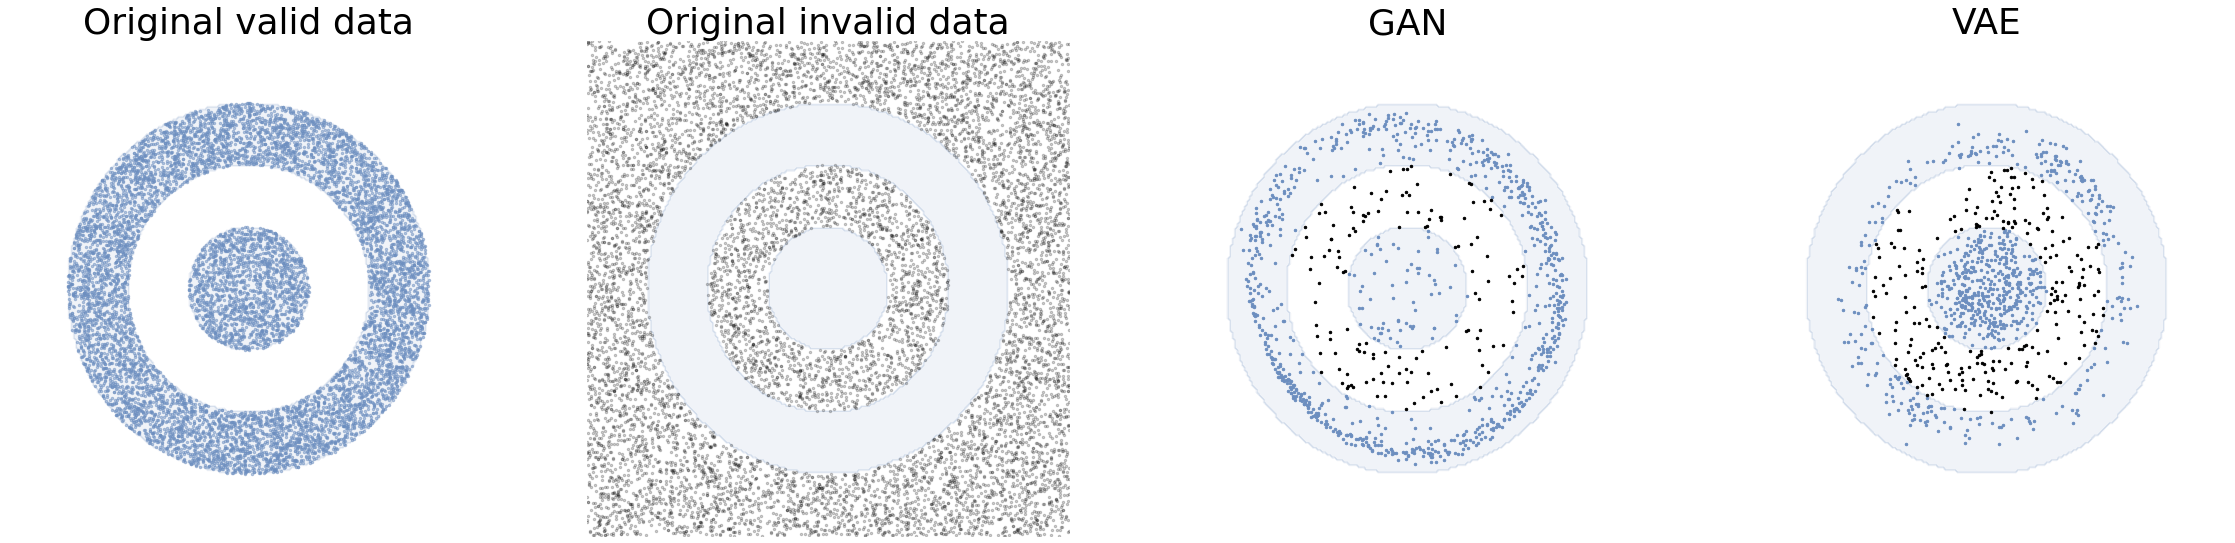

Problem 1 Scores:                       GAN       VAE
Predicted Constraint Satisfaction  0.872000  0.769200
Validity                           0.864000  0.755000
Nearest Invalid Sample             0.203862  0.180335
Average scores:                         GAN       VAE
Predicted Constraint Satisfaction  0.872000  0.769200
Validity                           0.864000  0.755000
Nearest Invalid Sample             0.203862  0.180335


In [8]:
functions=[]

sampling_func_2 = load_data.sample_uniform_wrapper(10000, 10000) #Uniform Sampling with Number of positive samples & Negative Samples
validity_func_2 = load_data.concentric_circles_val_wrapper(2)
rangearr_2 = np.array([[-1,1], [-1,1]])
functions.append([sampling_func_2, validity_func_2, None, rangearr_2, None, None])

reg_clf_params = None
config_params = [False, False, False, None, None, False]
train_params = [1, 0, 4, 5000] #Setting DPP weight to 0 for normal GAN
DTAI_params= [None, None, None]

methods=pd.Series()
methods["GAN"] = Padgan_variants.padgan_wrapper(config_params, train_params, DTAI_params, reg_clf_params, reg_clf_params)
methods["VAE"] = VAEs.VAE_wrapper([100, 128, 1e-3, 4, .05, False])


metrics=pd.Series()
metrics["Predicted Constraint Satisfaction"] = evaluation.predicted_constraint_satisfaction_wrapper(KNeighborsClassifier(n_neighbors=5))
metrics["Validity"] = None
metrics["Nearest Invalid Sample"] = evaluation.gen_neg_distance_wrapper("min")


validity_status = 1 #whether we are considering constraints
obj_status = 0 #wheteher we are considering functional perfomrance
conditional_status = 0 #whether we are considering conditioning
cond_dist=False #Whether conditional metrics are compared against conditional or marginal distribution

generated, timestr = fit_and_generate(functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status)
score_and_plot(generated, timestr, functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status, cond_dist)


**Performance and Target Achievement**

Lambda1 set to 0, DPP loss disabled; Ignoring CLF and REG...


C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\4033163131.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  methods=pd.Series()
C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\4033163131.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics=pd.Series()


GAN Training::   0%|          | 0/5000 [00:00<?, ?it/s]

No regressor provided! Fitting DNN Regressor using provided Parameters...
Epoch 1/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0423 - MSE: 0.0423 - val_loss: 0.0096 - val_MSE: 0.0096
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0137 - MSE: 0.0137 - val_loss: 0.0073 - val_MSE: 0.0073
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0122 - MSE: 0.0122 - val_loss: 0.0070 - val_MSE: 0.0070
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0117 - MSE: 0.0117 - val_loss: 0.0070 - val_MSE: 0.0070
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0109 - MSE: 0.0109 - val_loss: 0.0068 - val_MSE: 0.0068
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0105 - MSE: 0.0105 - val_loss: 0.0068 - val_MSE: 0.0068
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0101 - MSE: 0.0101 - val_loss: 0.0068 - val_MSE: 0.

GAN Training::   0%|          | 0/5000 [00:00<?, ?it/s]

Tensor("sequential/dense_47/BiasAdd:0", shape=(8, 2), dtype=float32)
Tensor("sequential/dense_47/BiasAdd:0", shape=(8, 2), dtype=float32)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Calculating Minimum Target Ratio
Calculating DTAI
Calculating Hypervolume
Calculating Generational Distance
Calculating Weighted Target Success Rate
Calculating Minimum Target Ratio
Calculating DTAI
Calculating Hypervolume
Calculating Generational Distance
Calculating Weighted Target Success Rate


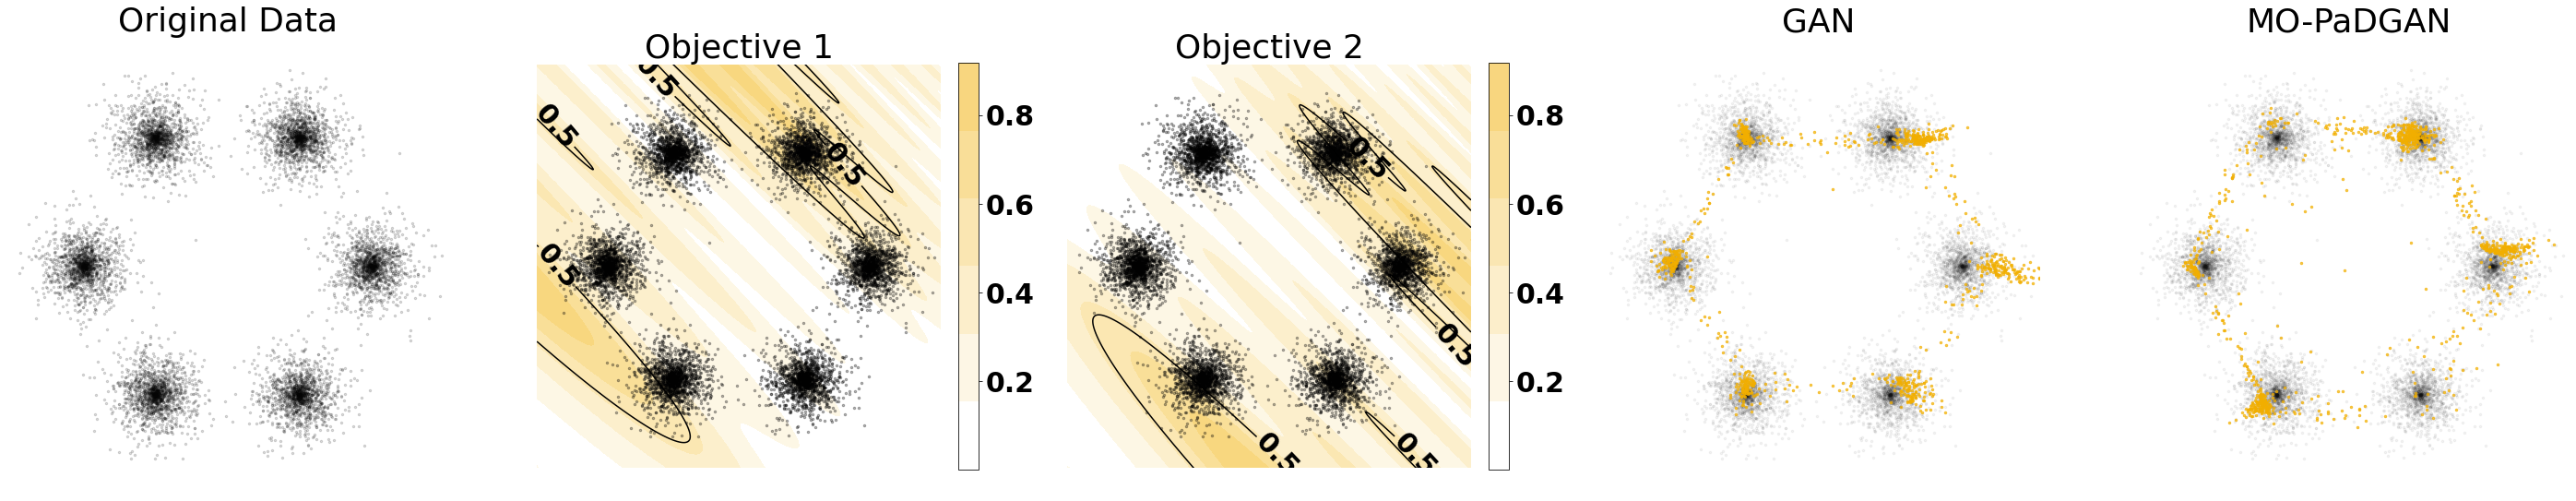

Problem 1 Scores:                  GAN  MO-PaDGAN
Minimum Target Ratio          0.549141   0.759082
DTAI                          0.340393   0.446815
Hypervolume                   0.564543   0.552140
Generational Distance         0.228070   0.332264
Weighted Target Success Rate  0.219000   0.438500
Signed Distance to Target    -0.266999  -0.138106
Average scores:                    GAN  MO-PaDGAN
Minimum Target Ratio          0.549141   0.759082
DTAI                          0.340393   0.446815
Hypervolume                   0.564543   0.552140
Generational Distance         0.228070   0.332264
Weighted Target Success Rate  0.219000   0.438500
Signed Distance to Target    -0.266999  -0.138106


In [9]:
functions=[]

Perf_val = load_data.all_val_wrapper()
pareto = np.stack([0.4705*np.linspace(0,1,1000), 0.4705*np.linspace(1,0,1000)], axis=1)
sampling_func = load_data.sample_circle_blobs_wrapper(10000, 6, 1.3, 0.22) #Uniform Sampling with Number of positive samples & Negative Samples
Perf_objs = [load_data.KNO1_a_wrapper(4,4), load_data.KNO1_b_wrapper(4,4)] 
rangearr = np.array([[-2,2], [-2,2]])
functions.append([sampling_func, Perf_val, Perf_objs, rangearr, None, None])

reg_clf_params = None
config_params = [False, False, False, None, None, False]
train_params = [1, 0, 4, 5000] #Setting DPP weight to 0 for normal GAN
DTAI_params= [None, None, None]

methods=pd.Series()
methods["GAN"] = Padgan_variants.padgan_wrapper(config_params, train_params, DTAI_params, reg_clf_params, reg_clf_params)

# Regressor/Classifier params: [dropout, layers, layersize, batchnorm, activation, patience, lr, batchsize, epochs]
reg_clf_params = [0.1, 2, 100, True, "Leaky ReLU", 30, 1e-4, 32, 100]
config_params = [False, False, False, "auto", "auto", False]
train_params = [5, 2, 4, 5000]
DTAI_params= ["auto", "auto", "auto"]
methods["MO-PaDGAN"] = Padgan_variants.padgan_wrapper(config_params, train_params, DTAI_params, reg_clf_params, reg_clf_params)

metrics=pd.Series()
target = np.array([0.5, 0.5])
a_ = np.array([1, 1])
p_ = np.array([1, 1])
direction = "maximize"
metrics["Minimum Target Ratio"] = evaluation.minimum_target_ratio_wrapper(direction, target)
metrics["DTAI"] = evaluation.DTAI_wrapper(direction, target, a_, p_)
metrics["Hypervolume"] = evaluation.Hypervolume_wrapper()
metrics["Generational Distance"] = evaluation.Generational_distance_wrapper(pareto)
metrics["Weighted Target Success Rate"] = evaluation.weighted_target_success_rate_wrapper(direction, target, p_)
metrics["Signed Distance to Target"] = evaluation.signed_distance_to_boundary_wrapper(direction, target, a_)


validity_status = 0 #whether we are considering constraints
obj_status = 1 #wheteher we are considering functional perfomrance
conditional_status = 0 #whether we are considering conditioning
cond_dist=False #Whether conditional metrics are compared against conditional or marginal distribution
plotobjs = target

generated, timestr = fit_and_generate(functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status)
score_and_plot(generated, timestr, functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status, cond_dist, plotobjs)


**Conditioning**

Lambda1 set to 0, DPP loss disabled; Ignoring CLF and REG...


C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\3782460493.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  methods=pd.Series()
C:\Users\Lyle\AppData\Local\Temp\ipykernel_53404\3782460493.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics=pd.Series()


GAN Training::   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1/100
79/79 [==============================] - 1s 6ms/step - loss: 0.7273 - reconstruction_loss: 0.3544 - kl_loss: 2.2418
Epoch 2/100
79/79 [==============================] - 0s 6ms/step - loss: 0.2062 - reconstruction_loss: 0.0574 - kl_loss: 2.7313
Epoch 3/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1722 - reconstruction_loss: 0.0463 - kl_loss: 2.4622
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1617 - reconstruction_loss: 0.0428 - kl_loss: 2.3379
Epoch 5/100
79/79 [==============================] - 1s 6ms/step - loss: 0.1571 - reconstruction_loss: 0.0390 - kl_loss: 2.3139
Epoch 6/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1504 - reconstruction_loss: 0.0378 - kl_loss: 2.2450
Epoch 7/100
79/79 [==============================] - 1s 7ms/step - loss: 0.1492 - reconstruction_loss: 0.0371 - kl_loss: 2.2256
Epoch 8/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1471 - reconstruction_loss: 0

Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:01<00:00,  6.79it/s]


Calculating F10


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:01<00:00,  6.87it/s]


Calculating F0.1


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:01<00:00,  6.89it/s]


Calculating AUC


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:01<00:00,  6.66it/s]


Calculating Maximum Mean Discrepancy
Calculating predicted_constraint_satisfaction
Calculating Gen-Data Distance
Calculating Data-Gen Distance
Calculating F1


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:01<00:00,  6.55it/s]


Calculating F10


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:01<00:00,  6.60it/s]


Calculating F0.1


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:01<00:00,  6.56it/s]


Calculating AUC


Calculating Precision/Recall:: 100%|===================================================| 10/10 [00:01<00:00,  6.66it/s]


Calculating Maximum Mean Discrepancy
Calculating predicted_constraint_satisfaction


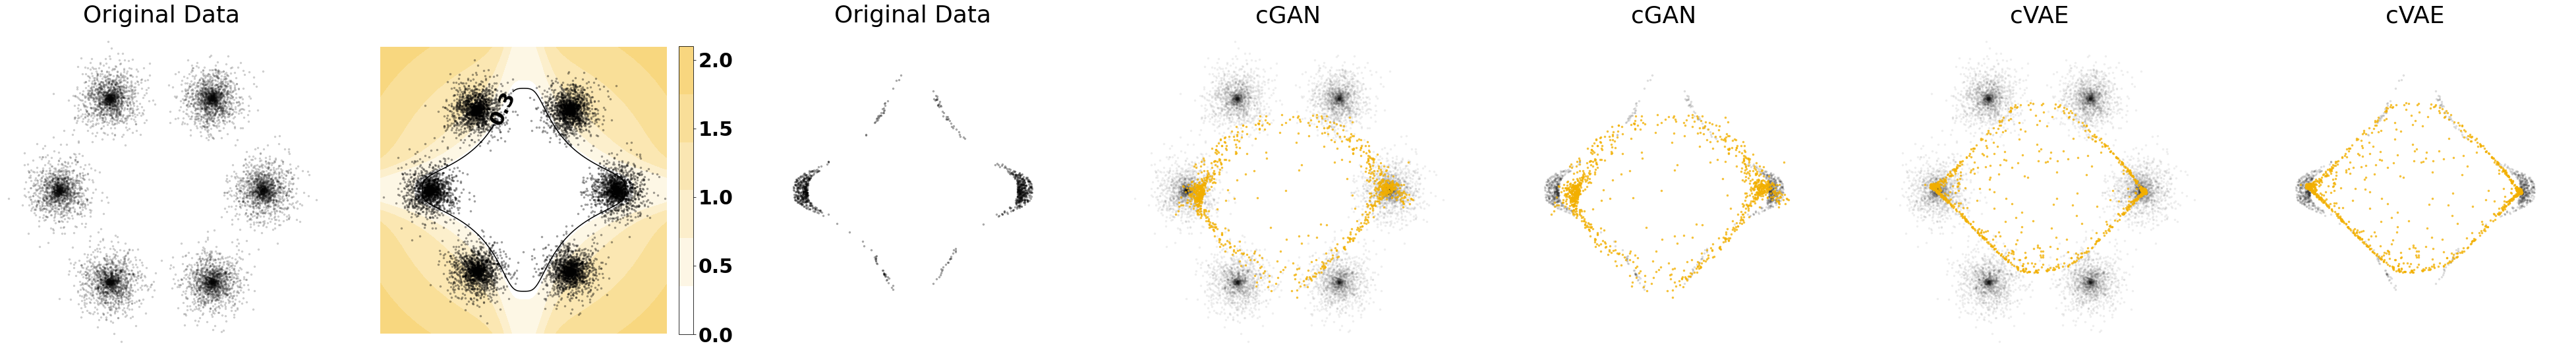

Problem 1 Scores:                cGAN      cVAE
Nearest Dataset Sample       0.134482  0.102674
Nearest Generated Sample     0.051870  0.079047
F1                           0.298707  0.588892
F10                          0.576327  0.798850
F0.1                         0.777355  0.884285
AUC-PR                       0.253703  0.573882
MMD                          0.045600  0.048756
Conditioning Reconstruction  0.016142  0.007938
Conditioning Adherence       0.014866  0.009529
Average scores:                  cGAN      cVAE
Nearest Dataset Sample       0.134482  0.102674
Nearest Generated Sample     0.051870  0.079047
F1                           0.298707  0.588892
F10                          0.576327  0.798850
F0.1                         0.777355  0.884285
AUC-PR                       0.253703  0.573882
MMD                          0.045600  0.048756
Conditioning Reconstruction  0.016142  0.007938
Conditioning Adherence       0.014866  0.009529


In [10]:
#Note: only continuous conditioning is currently supported

importlib.reload(load_data)
# importlib.reload(GANs)
importlib.reload(VAEs)

functions=[]

DM_val = load_data.all_val_wrapper()
pareto = np.stack([0.4705*np.linspace(0,1,1000), 0.4705*np.linspace(1,0,1000)], axis=1)
sampling_func = load_data.sample_circle_blobs_wrapper(10000, 6, 1.3, 0.22) #Uniform Sampling with Number of positive samples & Negative Samples
rangearr = np.array([[-2,2], [-2,2]])
cond_func = load_data.exp_obj_wrapper(1,1)
cond=0.3
functions.append([sampling_func, DM_val, None, rangearr, cond_func, cond])


reg_clf_params = None
config_params_cond = [False, False, False, None, None, True]
train_params = [1, 0, 4, 5000] #Setting DPP weight to 0 for normal GAN
DTAI_params= [None, None, None]

methods=pd.Series()
methods["cGAN"] = Padgan_variants.padgan_wrapper(config_params_cond, train_params, DTAI_params, reg_clf_params, reg_clf_params)
methods["cVAE"] = VAEs.VAE_wrapper([100, 128, 1e-3, 4, .05, True])

metrics=pd.Series()
metrics["Nearest Dataset Sample"] = evaluation.gen_data_distance_wrapper("x", "min")
metrics["Nearest Generated Sample"] = evaluation.data_gen_distance_wrapper("x", "min")
metrics["F1"] = evaluation.F_wrapper("x", 1)
metrics["F10"] = evaluation.F_wrapper("x", 10)
metrics["F0.1"] = evaluation.F_wrapper("x", 0.1)
metrics["AUC-PR"] = evaluation.AUC_wrapper("x")
metrics["MMD"] = evaluation.MMD_wrapper()

metrics["Conditioning Reconstruction"] = evaluation.predicted_conditioning_wrapper(KNeighborsRegressor(n_neighbors=5), cond)
metrics["Conditioning Adherence"] = None

validity_status = 0 #whether we are considering constraints
obj_status = 0 #wheteher we are considering functional perfomrance
conditional_status = 1 #whether we are considering conditioning
cond_dist=True #Whether conditional metrics are compared against conditional or marginal distribution


#Generate a new set of results
generated, timestr = fit_and_generate(functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status)
plotobjs = [cond]
#OR Load a set of results from a timestring:
# timestr= "20230204-161902"
# generated = np.load(f"Scores/Generated_samples_{timestr}.npy")

score_and_plot(generated, timestr, functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status, cond_dist, plotobjs)
# score_and_plot(generated, timestr, functions, methods, numinst, numgen, scaling, validity_status, obj_status, conditional_status, False, plotobjs)